In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

from tqdm import tqdm
import pandas as pd
from numba import njit

# Load data

In [2]:
# load input time series
X = np.loadtxt("twitter-earthquakes.dat")
T = len(X)

# load ground-truth label sequence
E = np.loadtxt("earthquakes.dat")
N_E = E.sum()

# parameters for the anomaly score (energy transient score, STA/LTA)
sta = 3
lta = 14

# compute anomaly score
Z = pd.Series(X)
Z = (Z.rolling(sta).mean()/(Z.rolling(lta).mean()+1)).fillna(0)
Z = Z.values

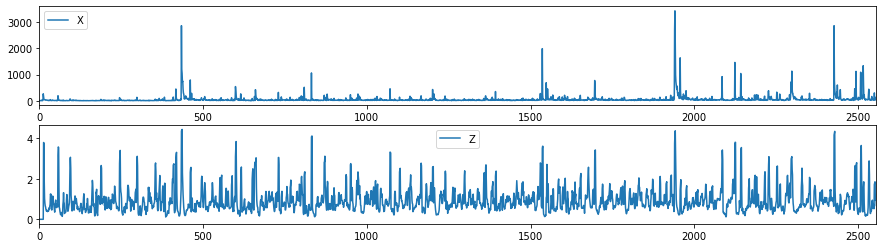

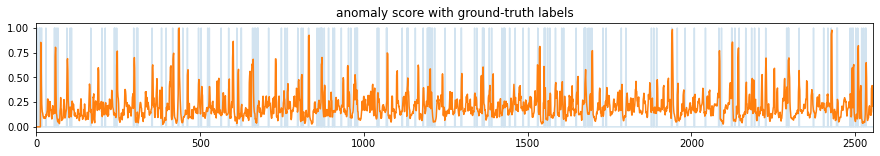

In [3]:
plt.figure(figsize=(15,4))
plt.subplot(211)
plt.plot(X, label="X")
plt.xlim(0, T-1)
plt.legend()
plt.subplot(212)
plt.plot(Z, label="Z")
plt.xlim(0, T-1)
plt.legend()
plt.show()

plt.figure(figsize=(15,2))
plt.title("anomaly score with ground-truth labels")
plt.plot(E, alpha=0.2)
plt.plot(Z/Z.max())
plt.xlim(0, T-1)
plt.show()

# Compute performance measures
... for various thresholds and temporal tolerances.

In [4]:
@njit
def recall(A, E, d):
    N_E = float(E.sum())
    return len([t for t in range(d, T-d) if (E[t] == 1) and np.sum(A[(t-d):(t+d)+1]) >= 1])/N_E

@njit
def precision(A, E, d):
    N_A = float(A.sum())
    return len([t for t in range(d, T-d) if (A[t] == 1) and np.sum(E[(t-d):(t+d)+1]) >= 1])/N_A

In [5]:
# sequence of thresholds to evaluate (uniform grid of quantiles)
rhos = np.linspace(0, 1, 50, endpoint=False)
taus = np.percentile(Z, rhos*100)

# number of ground-truth anomalies and
# detected anomalies for every threshold
N_Es = np.ones_like(rhos)*np.sum(E) # constant w.r.t. threshold
N_As = np.array([(Z > tau).sum() for tau in taus])

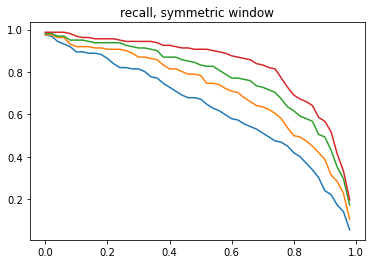

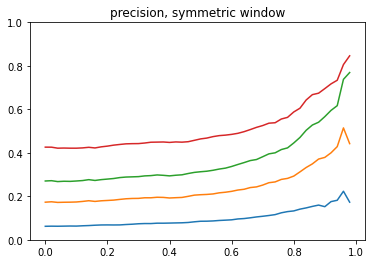

In [6]:
# temporal tolerances to evaluate
deltas = [0, 1, 2, 4]

recalls = {}
for d in deltas:
    recalls[d] = np.zeros_like(rhos) 
    for i, rho in enumerate(rhos):
        A = (Z > taus[i])*1
        recalls[d][i] = recall(A, E, d)
    plt.plot(rhos, recalls[d])
plt.title("recall, symmetric window")
plt.show()

precisions = {}
for d in deltas:
    precisions[d] = np.zeros_like(rhos) 
    for i, rho in enumerate(rhos):
        A = (Z > taus[i])*1
        precisions[d][i] = precision(A, E, d)
    plt.plot(rhos, precisions[d])
plt.ylim(0,1)
plt.title("precision, symmetric window")
plt.show()

# Monte Carlo simulations
... with fixed temporal tolerance.

In [7]:
# temporal tolerance to evaluate
delta = 2

# number of Monte Carlo simulations
simuls = 10000

In [8]:
# compute precision and recall on ground-truth labels
rec  = np.zeros_like(rhos)
prec = np.zeros_like(rhos)
for i, rho in enumerate(rhos):
    A = (Z > taus[i])*1
    rec[i] = recall(A, E, delta)
    prec[i] = precision(A, E, delta)

# compute precision and recall on randomly permuted ground-truth labels
simul_recs = [None] * simuls
simul_precs = [None] * simuls
for s in tqdm(range(simuls)):
    simul_E = np.random.permutation(E)
    simul_rec  = np.zeros_like(rhos)
    simul_prec = np.zeros_like(rhos)
    for i, rho in enumerate(rhos):
        A = (Z > taus[i])*1
        simul_rec[i]  = recall(A, simul_E, delta)
        simul_prec[i] = precision(A, simul_E, delta)
    simul_recs[s]  = simul_rec
    simul_precs[s] = simul_prec

simul_recs = np.array(simul_recs)
simul_precs = np.array(simul_precs)

100%|██████████| 10000/10000 [00:37<00:00, 267.59it/s]


## Visualization of the simulated performances for all thresholds
... limited to the first 50 simulations.

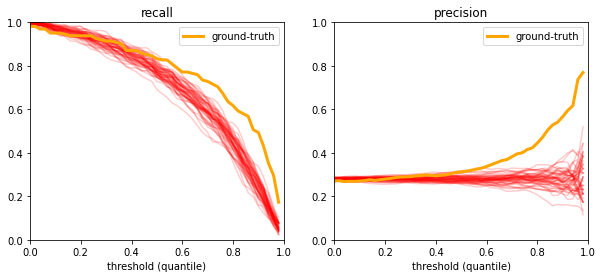

In [9]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(rhos, simul_recs.transpose()[:,:50], 'r', alpha=0.2)
plt.plot(rhos, rec, 'orange', label='ground-truth', lw=3)
plt.ylim((0,1))
plt.xlim((0,1))
plt.title("recall")
plt.legend()
plt.xlabel("threshold (quantile)")

plt.subplot(122)
plt.plot(rhos, simul_precs.transpose()[:,:50], 'r', alpha=0.2)
plt.plot(rhos, prec, 'orange', label='ground-truth', lw=3)
plt.ylim((0,1))
plt.xlim((0,1))
plt.title("precision")
plt.xlabel("threshold (quantile)")
plt.legend()
plt.show()

## Visualization of the simulated performance distribution for single threshold

In [10]:
# For consistency with the paper, we visualize the distribution of
# the TP entries of the confusion matrices. For this purpose, we
# have to undo the normalization of the precision and recall measures.
simul_paaad = simul_precs * N_As.reshape(1,-1)
simul_padaa = simul_recs * N_Es.reshape(1,-1)
paaad = prec * N_As
padaa = rec * N_Es

In [11]:
# Index of the threshold/quantile to use within the sequence of thresholds/quantiles
rho_idx = 45

print(f"delta={delta}")
print(f"quantile={rhos[rho_idx]}")

delta=2
quantile=0.9


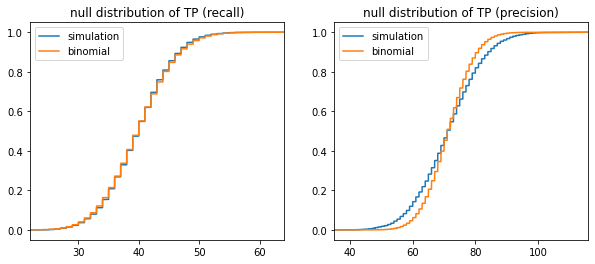

In [12]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.title('null distribution of TP (recall)')
plt.plot(np.sort(simul_padaa[:,rho_idx]), np.linspace(0,1,simuls), label="simulation")
plt.plot(np.linspace(0,N_Es[rho_idx],simuls), ss.binom.cdf(np.linspace(0,N_Es[rho_idx],simuls), N_Es[rho_idx], simul_padaa[:,rho_idx].mean()/N_Es[rho_idx]), label="binomial")
plt.xlim(np.min(simul_padaa[:,rho_idx]), np.max(simul_padaa[:,rho_idx]))
plt.legend()

plt.subplot(122)
plt.title('null distribution of TP (precision)')
plt.plot(np.sort(simul_paaad[:,rho_idx]), np.linspace(0,1,simuls), label="simulation")
plt.plot(np.linspace(0,N_As[rho_idx],simuls), ss.binom.cdf(np.linspace(0,N_As[rho_idx],simuls), N_As[rho_idx], simul_paaad[:,rho_idx].mean()/N_As[rho_idx]), label="binomial")
plt.xlim(np.min(simul_paaad[:,rho_idx]), np.max(simul_paaad[:,rho_idx]))
plt.legend()
plt.show()

In [17]:
padaa_greater_or_equal = np.sum(simul_padaa[:,rho_idx] >= padaa[rho_idx])
padaa_pval = (padaa_greater_or_equal + 1) / (simuls + 1)
print(f"TP (recall)\t[PAd-AA]\tp-value = {padaa_pval:.4f}")

paaad_greater_or_equal = np.sum(simul_paaad[:,rho_idx] >= paaad[rho_idx])
paaad_pval = (paaad_greater_or_equal + 1) / (simuls + 1)
print(f"TP (precision)\t[PA-AAd]\tp-value = {paaad_pval:.4f}")

TP (recall)	[PAd-AA]	p-value = 0.0001
TP (precision)	[PA-AAd]	p-value = 0.0001
